In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


This version of the dataset adds 15 new species to the previous version. In addition using a dataset analysis tool I was able to clean the dataset so that there are no duplicate or near-duplicate images in the dataset. This ensures no leakage between the train, test and validation datasets. Also so defective low information images were also removed. So now you are using a clean dataset.
Data set of 15 bird species. 2295 training images, 75 test images(5 images per species) and 75 validation images(5 images per species. This is a very high quality dataset where there is only one bird in each image and the bird typically takes up at least 50% of the pixels in the image. As a result even a moderately complex model will achieve training and test accuracies in the mid 90% range. Note: all images are original and not created by augmentation
All images are 224 X 224 X 3 color images in jpg format. Data set includes a train set, test set and validation set. Each set contains 525 sub directories, one for each bird species. The data structure is convenient if you use the Keras ImageDataGenerator.flow_from_directory to create the train, test and valid data generators. The data set also include a file birds.csv. This cvs file contains 5 columns. The filepaths column contains the relative file path to an image file. The labels column contains the bird species class name associated with the image file. The scientific label column contains the latin scientific name for the image. The data set column denotes which dataset (train, test or valid) the filepath resides in. The class_id column contains the class index value associated with the image file's class.
NOTE: The test and validation images in the data set were hand selected to be the "best" images so your model will probably get the highest accuracy score using those data sets versus creating your own test and validation sets. However the latter case is more accurate in terms of model performance on unseen images.
Images were gathered from internet searches by species name. Once the image files for a species was downloaded they were checked for the presemce of duplicate or near duplicate images. All duplicate or near duplicate images detected were deleted in order to prevent their being images common between the training, test and validation sets.
After that the images were cropped so that the bird in most cases occupies at least 50% of the pixel in the image. Then the images were resized to 224 X 224 X3 in jpg format. The cropping ensures that when processed by a CNN their is adequate information in the images to create a highly accurate classifier. Even a moderately robust model should achieve training, validation and test accuracies in the high 90% range. Because of the large size of the dataset I recommend if you try to train a model use and image size of 150 X 150 X 3 in order to reduce training time. All files were also numbered sequential starting from one for each species. So test images are named 1.jpg to 5.jpg. Similarly for validation images. Training images are also numbered sequentially with "zeros" padding. For example 001.jpg, 002.jpg ….010.jpg, 011.jpg …..099.jpg, 100jpg, 102.jpg etc. The zero's padding preserves the file order when used with python file functions and Keras flow from directory.
The training set is not balanced, having a varying number of files per species. However each species has at least 130 training image files.
One significant shortcoming in the data set is the ratio of male species images to female species images. About 80% of the images are of the male and 20% of the female. Males typical are far more diversely colored while the females of a species are typically bland. Consequently male and female images may look entirely different .Almost all test and validation images are taken from the male of the species. Consequently the classifier may not perform as well on female specie images.

In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
dataset_path = "/content/drive/MyDrive/notebook/datasets"

In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path =dataset_path +'/train'
valid_path = dataset_path +'/val'
test_path = dataset_path + '/test'

In [7]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in inception.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [8]:
  # useful for getting number of output classes
folders = glob(train_path +'/*')

In [9]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)


# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2295 images belonging to 15 classes.


In [14]:
val_set = val_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 75 images belonging to 15 classes.


In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_set,
  validation_data=val_set,
  epochs=20,
  steps_per_epoch=len(train_set),
  validation_steps=len(val_set)
)

<ipython-input-15-2e0d98d6dde1>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20
72/72 [==============================] - 447s 6s/step - loss: 1.8138 - accuracy: 0.8336 - val_loss: 0.4048 - val_accuracy: 0.9600
Epoch 2/20
72/72 [==============================] - 79s 1s/step - loss: 0.2706 - accuracy: 0.9651 - val_loss: 0.3579 - val_accuracy: 0.9867
Epoch 3/20
72/72 [==============================] - 73s 1s/step - loss: 0.2690 - accuracy: 0.9725 - val_loss: 0.0113 - val_accuracy: 0.9867
Epoch 4/20
72/72 [==============================] - 75s 1s/step - loss: 0.3067 - accuracy: 0.9699 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 5/20
72/72 [==============================] - 72s 1s/step - loss: 0.1896 - accuracy: 0.9817 - val_loss: 1.4742e-04 - val_accuracy: 1.0000
Epoch 6/20
72/72 [==============================] - 74s 1s/step - loss: 0.2371 - accuracy: 0.9782 - val_loss: 0.3026 - val_accuracy: 0.9867
Epoch 7/20
72/72 [==============================] - 77s 1s/step - loss: 0.1866 - accuracy: 0.9847 - val_loss: 0.3121 - val_accuracy: 0.9867
Epoch 8/20
72/7

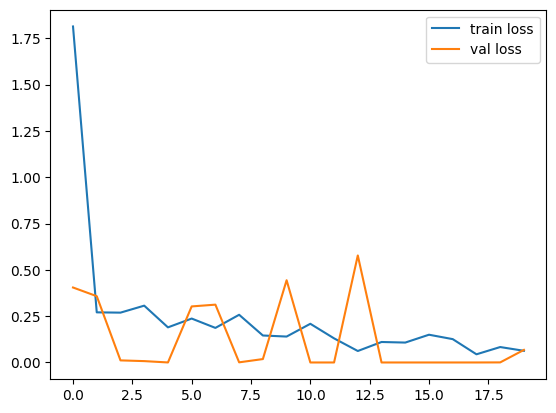

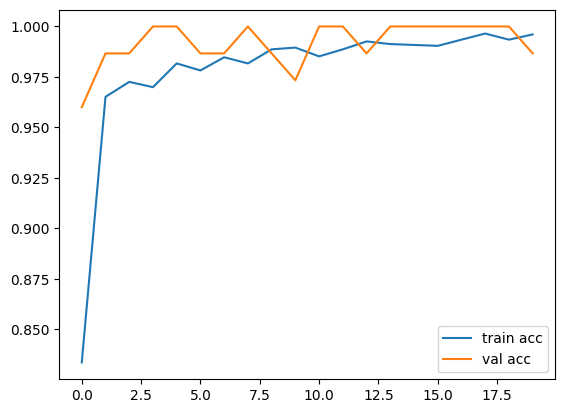

<Figure size 640x480 with 0 Axes>

In [16]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [17]:
# save it as a h5 file in inversion v3 model


from tensorflow.keras.models import load_model

model.save('mobilenetv2.h5')

In [18]:
#load the model

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model=load_model('mobilenetv2.h5')


In [19]:
ref = dict(zip(list(train_set.class_indices.values()),list(train_set.class_indices.keys())))

In [20]:
def prediction(path):
  img = image.load_img(path, target_size=(224, 224))
  i = image.img_to_array(img)
  i = np.expand_dims(i, axis=0)
  img = preprocess_input(i)
  pred = np.argmax(model.predict(img), axis=1)
  print(f"the image belongs to {ref[pred[0]]}")

In [21]:
path = "/content/drive/MyDrive/notebook/datasets/test/DARJEELING WOODPECKER/3.jpg"
prediction(path)

1/1 [==============================] - 1s 859ms/step
the image belongs to DARJEELING WOODPECKER


In [22]:
train_set.class_indices

{'ABBOTTS BABBLER': 0,
 'BAIKAL TEAL': 1,
 'CAATINGA CACHOLOTE': 2,
 'DARJEELING WOODPECKER': 3,
 'EASTERN BLUEBIRD': 4,
 'FAIRY BLUEBIRD': 5,
 'GAMBELS QUAIL': 6,
 'HAMERKOP': 7,
 'IBERIAN MAGPIE': 8,
 'JABIRU': 9,
 'KAGU': 10,
 'LARK BUNTING': 11,
 'MAGPIE GOOSE': 12,
 'NICOBAR PIGEON': 13,
 'OCELLATED TURKEY': 14}

In [1]:
# modeling

In [23]:
#load the model
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('mobilenetv2.h5')
from PIL import Image


In [25]:
def prediction(path):
    img = image.load_img(path, target_size=(224, 224))
    i = image.img_to_array(img)
    import numpy as np
    i = np.expand_dims(i, axis=0)
    img = preprocess_input(i)
    pred = np.argmax(model.predict(img), axis=1)

    print(pred)

path = r"/content/drive/MyDrive/notebook/datasets/test/FAIRY BLUEBIRD/3.jpg"
prediction(path)

1/1 [==============================] - 1s 635ms/step
[5]
